In [1]:
%matplotlib inline

from io import BytesIO
import os
from dotenv import load_dotenv
import logging
from pprint import pprint
import random
import requests

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from pinecone import Pinecone, ServerlessSpec
import torch
from transformers import CLIPProcessor, CLIPModel

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

load_dotenv()

True

In [2]:
categories_str = "tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute"
categories = [s.strip() for s in categories_str.split(',')]

# Set up train directory
dataset_dir = 'imagenette2-160/imagenette2-160'
train_dir = os.path.join(dataset_dir, 'train')

# Create a mapping from train's subdirectories to the category each represents
subdirs = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
mapping = { subdir: category for subdir, category in zip(subdirs, categories) }
pprint(mapping)

{'n01440764': 'tench',
 'n02102040': 'English springer',
 'n02979186': 'cassette player',
 'n03000684': 'chain saw',
 'n03028079': 'church',
 'n03394916': 'French horn',
 'n03417042': 'garbage truck',
 'n03425413': 'gas pump',
 'n03445777': 'golf ball',
 'n03888257': 'parachute'}


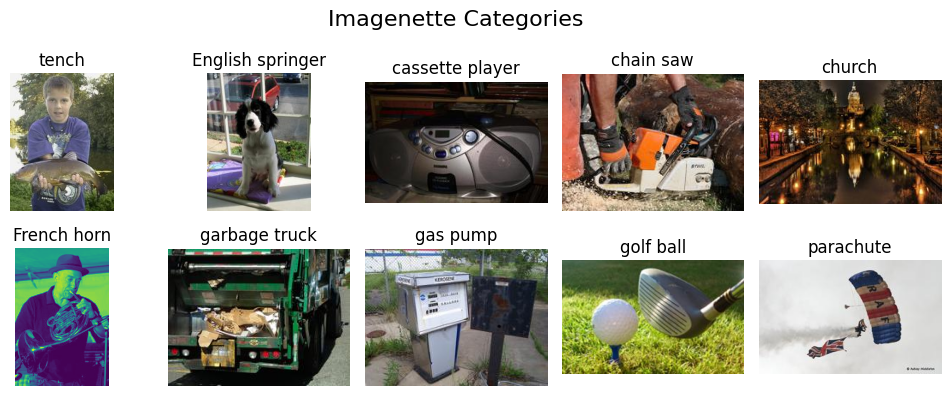

In [3]:
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Imagenette Categories', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through subdirectories
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(train_dir, subdir)

    # Get all JPEG files in the subdirectory
    jpeg_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.jpg', '.jpeg'))]

    if jpeg_files:
        # Select a random image
        random_image = random.choice(jpeg_files)
        img_path = os.path.join(subdir_path, random_image)

        # Open and display the image
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(mapping[subdir])
        axes[i].axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [5]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [6]:
import requests
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")
image_features = model.get_image_features(**inputs)


In [7]:
image_features.shape

torch.Size([1, 512])

In [8]:
# Pick an image from our dataset
subdir_path = os.path.join(train_dir, subdirs[0])
image_filename = os.listdir(subdir_path)[0]
image_path = os.path.join(subdir_path, image_filename)

# Preprocess the image with the CLIP image preprocessor
# and use the model to generate an embedding
image = Image.open(image_path).convert('RGB')
inputs = processor(images=image, return_tensors="pt", padding=True)
with torch.no_grad():
    embedding = model.get_image_features(**inputs)

In [9]:
embedding.shape

torch.Size([1, 512])

In [10]:
embedding.squeeze().shape

torch.Size([512])

In [11]:
n_images = 8
image_filenames = os.listdir(subdir_path)[:n_images]
image_paths = [os.path.join(subdir_path, f) for f in image_filenames]
images = [Image.open(image_path).convert('RGB') for image_path in image_paths]
inputs = processor(images=images, return_tensors="pt", padding=True)
with torch.no_grad():
    embeddings = model.get_image_features(**inputs)

embeddings.shape

torch.Size([8, 512])

In [12]:
def generate_embedding(model, processor, image_path):
  """
  Generate an embedding for an image using the CLIP model and processor.

  This function takes an image file, processes it using the provided CLIP processor,
  and then uses the CLIP model to generate an embedding representation of the image.

  Args:
      model (CLIPModel): A pre-trained CLIP model.
      processor (CLIPProcessor): A CLIP processor for preparing the image input.
      image_path (str): The file path to the image.

  Returns:
      list: A list of 512 float values representing the image embedding.

  Raises:
      FileNotFoundError: If the specified image file does not exist.
      ValueError: If the image cannot be properly processed or embedded.

  Note:
      The image is converted to RGB mode before processing to ensure compatibility
      with the CLIP model.

  Example:
      >>> model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
      >>> processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
      >>> embedding = generate_embedding(model, processor, "path/to/image.jpg")
  """

  if not os.path.exists(image_path):
    raise FileNotFoundError(f"The file '{image_path}' does not exist.")
  else:
    print(f"The file '{image_path}' exists.")
        
  image = Image.open(image_path).convert('RGB')

  inputs = processor(images=image, return_tensors="pt", padding=True)
  with torch.no_grad():
    embedding = model.get_image_features(**inputs)
  return embedding.squeeze()


def process_images_dir(model, processor, image_dir):
  """
  Generate embeddings for all the images in the image directory using the CLIP model.

  Args:
      model (CLIPModel): A pre-trained CLIP model.
      processor (CLIPProcessor): A CLIP processor for preparing the image inputs.
      image_dir (str): The path to the directory containing the images to process.
      n_images (int): The number of images to process.

  Returns:
      tuple: A tuple containing two lists:
          - embeddings (list of list): A list of image embeddings, where each embedding
            is a list of 512 float values.
          - image_paths (list of str): A list of file paths corresponding to the processed images.

  Raises:
      FileNotFoundError: If the specified image directory does not exist.
      PermissionError: If there are insufficient permissions to read the directory or its files.

  Note:
      This function only processes files with the extensions .png, .jpg, or .jpeg
      (case-insensitive).

  Example:
      >>> model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
      >>> processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
      >>> embeddings, paths = process_images_dir(model, processor, "path/to/image/directory")
  """
  embeddings = []
  image_paths = []
  ###################################################################
  # TODO: Fill in your code here
  ###################################################################

  if not os.path.isdir(image_dir):
    raise FileNotFoundError(f"The directory '{image_dir}' does not exist.")
  else:
    print(f"The directory '{image_dir}' exists.")



    
  image_filenames = os.listdir(image_dir)
  print("image_filenames=",image_filenames)
  image_paths = [os.path.join(image_dir, f) for f in image_filenames]


  for image_path in image_paths:
    embeddings.append(generate_embedding(model, processor, image_path))

    
###################################################################
  # END OF YOUR CODE
  ###################################################################
  return embeddings, image_paths


In [13]:
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')

pc = Pinecone(api_key=PINECONE_API_KEY)

In [14]:
index_name = "david-clip-index" # You can name the index whatever you want
###################################################################
# TODO: Fill in your code here
###################################################################
n_embd = 512
metric = "cosine"
###################################################################
# END OF YOUR CODE
###################################################################

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=n_embd,
        metric=metric,
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )
    print(f"Created index: {index_name}")
else:
    print(f"Index already exists: {index_name}")

Index already exists: david-clip-index


In [15]:
pcIndex = pc.Index(index_name)
index_stats = pcIndex.describe_index_stats()

print(f"The index contains {index_stats['dimension']}-dimensional vectors/embeddings.")
print(f"A total of {index_stats['total_vector_count']} vectors have been uploaded to the index.")

The index contains 512-dimensional vectors/embeddings.
A total of 0 vectors have been uploaded to the index.


In [16]:
###################################################################
# TODO: Generate records for each image and upload them to your
#       Pinecone database
###################################################################

namespace = "linalg101-part3-david" # TODO: Give your namespace any name you want

def list_subdirectories(directory):
  subdirs = []
  for d in os.listdir(directory):
    fullpath = os.path.join(directory, d)
    if os.path.isdir(fullpath):
      subdirs.append(fullpath)
  return subdirs

def list_image_files(directory):
  image_extensions = ('.jpg', '.jpeg', '.png')
  image_files = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.lower().endswith(image_extensions):
          image_files.append(os.path.join(root, file))
  return image_files

...

dataset_dir = 'imagenette2-160/imagenette2-160'
train_dir = os.path.join(dataset_dir, 'train')
print("train_dir",train_dir)

subdirs = list_subdirectories(train_dir)
print("subdirs",subdirs)

allVectors = {}

for subdir in subdirs:
    embeddings, image_paths = process_images_dir(model, processor, subdir)
    allVectors[subdir] = []
    for index, value in enumerate(embeddings):
        allVectors[subdir].append({
            "id": image_paths[index],
            "values": value.tolist()
        })

train_dir imagenette2-160/imagenette2-160\train
subdirs ['imagenette2-160/imagenette2-160\\train\\n01440764', 'imagenette2-160/imagenette2-160\\train\\n02102040', 'imagenette2-160/imagenette2-160\\train\\n02979186', 'imagenette2-160/imagenette2-160\\train\\n03000684', 'imagenette2-160/imagenette2-160\\train\\n03028079', 'imagenette2-160/imagenette2-160\\train\\n03394916', 'imagenette2-160/imagenette2-160\\train\\n03417042', 'imagenette2-160/imagenette2-160\\train\\n03425413', 'imagenette2-160/imagenette2-160\\train\\n03445777', 'imagenette2-160/imagenette2-160\\train\\n03888257']
The directory 'imagenette2-160/imagenette2-160\train\n01440764' exists.
image_filenames= ['ILSVRC2012_val_00000293.JPEG', 'ILSVRC2012_val_00002138.JPEG', 'ILSVRC2012_val_00003014.JPEG', 'ILSVRC2012_val_00006697.JPEG', 'ILSVRC2012_val_00007197.JPEG', 'ILSVRC2012_val_00009346.JPEG', 'ILSVRC2012_val_00009379.JPEG', 'ILSVRC2012_val_00009396.JPEG', 'ILSVRC2012_val_00010306.JPEG', 'ILSVRC2012_val_00011233.JPEG', 'IL

In [17]:

for subDirKey, subDirValues in allVectors.items():
    print(f"Upserting vectors for directory: {subDirKey}")
    pcIndex.upsert(
        vectors = subDirValues,
        namespace=namespace
    )
        

###################################################################
# END OF YOUR CODE
###################################################################

Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n01440764
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n02102040
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n02979186
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03000684
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03028079
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03394916
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03417042
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03425413
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03445777
Upserting vectors for directory: imagenette2-160/imagenette2-160\train\n03888257


In [18]:
pcIndex = pc.Index(index_name)
index_stats = pcIndex.describe_index_stats()

print(f"The index contains {index_stats['dimension']}-dimensional vectors/embeddings.")
print(f"A total of {index_stats['total_vector_count']} vectors have been uploaded to the index.")

The index contains 512-dimensional vectors/embeddings.
A total of 9469 vectors have been uploaded to the index.


In [19]:
#pcIndex.delete(delete_all=True, namespace=namespace)

#https://www.historyhit.com/app/uploads/bis-images/5150644/Church-of-the-Annunciation-%E2%80%93-Nazareth-788x537.jpg|

In [32]:
def get_image_from_url(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content)).convert('RGB')

###################################################################
# TODO: Generate an embedding for the image you found
#       and query the vector database for the 3 most similar images
#       to your query image.
###################################################################

# Sample query image (church)
image_url = "https://www.historyhit.com/app/uploads/bis-images/5150644/Church-of-the-Annunciation-%E2%80%93-Nazareth-788x537.jpg"

churchImage = get_image_from_url(image_url)

inputs = processor(images=churchImage, return_tensors="pt", padding=True)

inputImageEmbedding = None

with torch.no_grad():
    inputImageEmbedding = model.get_image_features(**inputs).squeeze()

results = pcIndex.query(
  namespace=namespace,
  vector=inputImageEmbedding.tolist(),
  top_k=3,
  include_values=True
)

matches = results.matches

###################################################################
# END OF YOUR CODE
###################################################################

In [33]:
print(matches)

[{'id': 'imagenette2-160/imagenette2-160\\train\\n03028079\\n03028079_2526.JPEG',
 'score': 0.733760357,
 'values': [0.0190283731,
            -0.0464369953,
            -0.119020283,
            0.0850195289,
            -0.631009936,
            -0.319916815,
            -0.255342036,
            0.046203196,
            -0.572284341,
            0.00661444664,
            0.0162152648,
            0.0336327888,
            0.583849907,
            0.203744277,
            0.165254816,
            0.0534482151,
            -0.153485164,
            0.0075525865,
            0.19770202,
            -0.205865026,
            0.27350378,
            -0.38145268,
            -0.0909980312,
            -0.522404253,
            0.052842088,
            0.241461173,
            0.128871113,
            0.0794574916,
            0.616839349,
            -0.091545254,
            -0.16685912,
            -0.0704804584,
            0.0260023922,
            0.0105576813,
            0.2634630

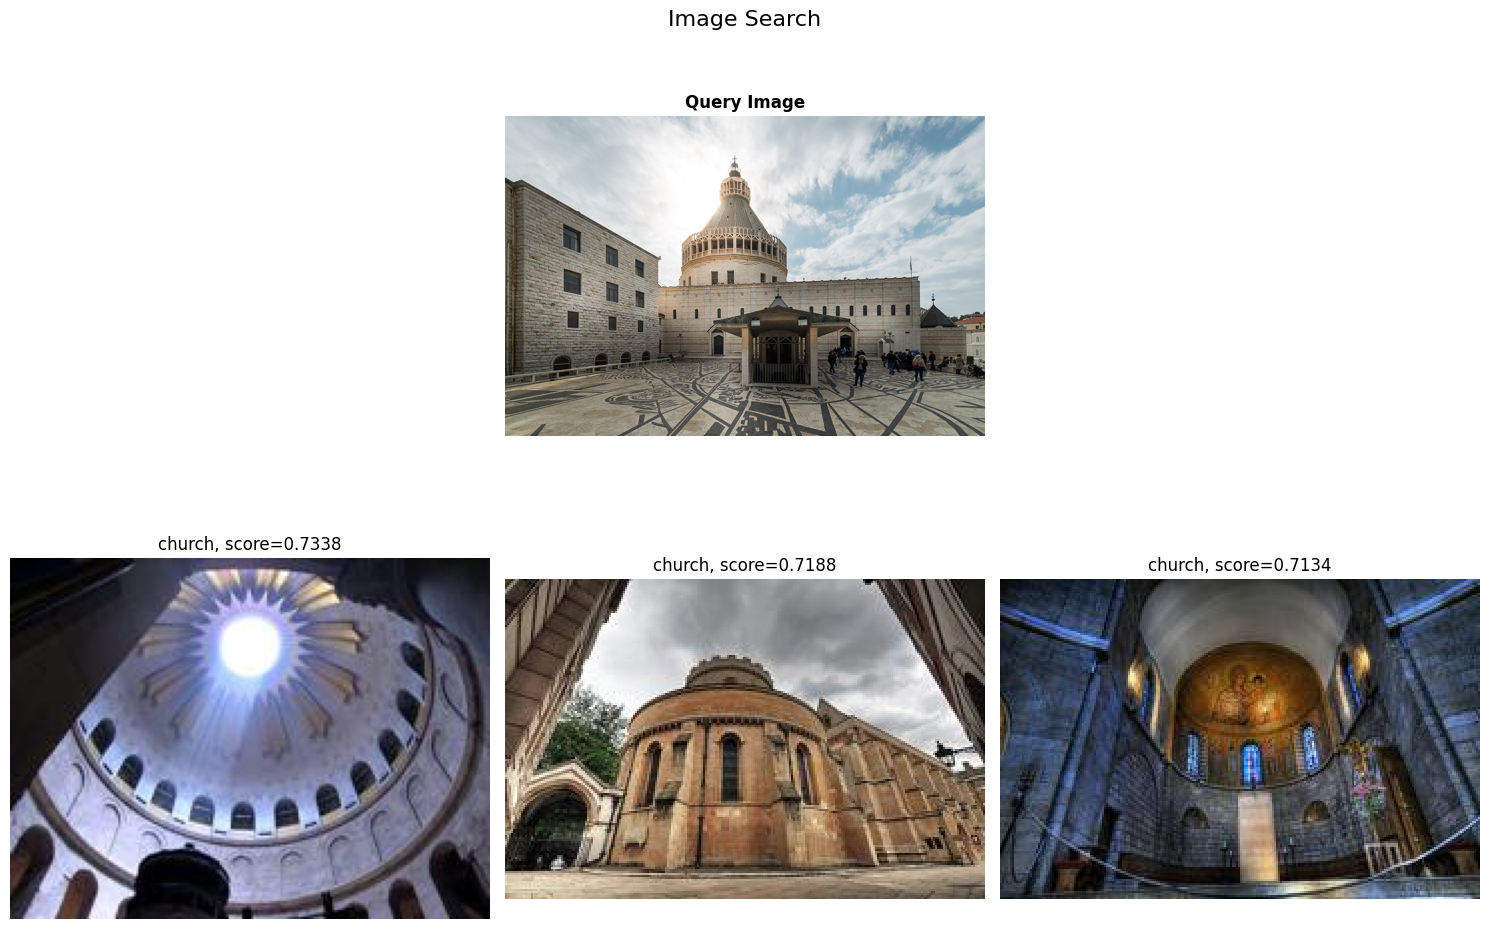

In [34]:
def display_images_grid(query_image_url, image_paths, scores):
    # Calculate the number of images (query + results)
    num_images = len(image_paths) + 1

    # Create a figure with 2 rows: 1 for query, 1 for results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Image Search", fontsize=16)

    # Display query image
    query_img = get_image_from_url(query_image_url)
    axes[0, 1].imshow(query_img)
    axes[0, 1].axis('off')
    axes[0, 1].set_title("Query Image", fontweight='bold')

    # Turn off unused subplots in the first row
    axes[0, 0].axis('off')
    axes[0, 2].axis('off')

    # Loop through the result image paths and display each image
    for i, (path, score) in enumerate(zip(image_paths, scores)):
        img = Image.open(path)
        containing_dir = os.path.basename(os.path.dirname(path))
        filename = os.path.basename(path)
        title = mapping[containing_dir]

        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"{title}, score={score:.4f}")

    plt.tight_layout()
    plt.show()

display_images_grid(image_url, [ r['id'] for r in matches ], [ r['score'] for r in matches ])

# Summary of this project

-This project uses CLIP's pre-trained neural network (Downloaded using Hugging Face)

-It downloads images from an image database (from Imagenette)

-The CLIP model allows us to generate embeddings (images turned into meaningful vectors) for each picture

-All of the embeddings are stored in a vector database (using Pinecone)

-Using a new picture with new embeddings the vector database is queried to find the most similar pictures.

-The most similar pictures are displayed and the image path is used to determine the category of picture.